# Setup

In [1]:
# Import libraries
import requests # to download html code
from bs4 import BeautifulSoup # to navigate through the html code
import pandas as pd
import numpy as np
import re # for cleanup
import spotipy
from config import *
import json
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= Client_ID, client_secret= Client_Secret))

## Top 100

In [3]:
# url used for top100
url = "https://www.billboard.com/charts/hot-100"

In [4]:
# Download html
response = requests.get(url)
# 200 status code means OK! response.status_code
print(response.status_code)

200


In [5]:
# Parse html
soup = BeautifulSoup(response.text, 'html.parser')
# Check up
# soup

In [6]:
songnametext = soup.select("span.chart-element__information__song")[0].get_text()
songnametext

'Montero (Call Me By Your Name)'

In [7]:
Songnames = []
for elem in soup.select("span.chart-element__information__song"):
    Songnames.append(elem.get_text())


In [8]:
artisttext = soup.select("span.chart-element__information__artist")[0].get_text()
artisttext

'Lil Nas X'

In [9]:
Artists = []
for elem in soup.select("span.chart-element__information__artist"):
    Artists.append(elem.get_text())

In [10]:
Top_100 = pd.DataFrame({'Songtitle': Songnames, 'Artist(s)': Artists})
Top_100

,Songtitle,Artist(s)
0,Montero (Call Me By Your Name),Lil Nas X
1,Peaches,Justin Bieber Featuring Daniel Caesar & Giveon
2,Leave The Door Open,Silk Sonic (Bruno Mars & Anderson .Paak)
3,Up,Cardi B
4,Drivers License,Olivia Rodrigo
...,...,...
95,Shock Da World,Rod Wave
96,You Got It,VEDO
97,Sneaky Links,Rod Wave
98,Nobody,Dylan Scott


## Spotify

In [11]:
path = '../Gnoosic/Spotify.csv'
Spotify =  pd.read_csv(path)
Spotify.head()

,Songtitle,Artist(s),uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,beverly,Koi,spotify:track:2pTW1GkqQ6dPTBOff2ZqQc,0.735,0.491,0,-7.766,0,0.0427,0.15700,0.000060,0.121,0.5740,167.130
1,Titanium (feat. Sia),"David Guetta, Sia",spotify:track:47Z5890IcjSed81ldeLgqc,0.602,0.796,0,-3.657,0,0.1030,0.06820,0.120000,0.150,0.2650,126.060
2,LOVE. FEAT. ZACARI.,"Kendrick Lamar, Zacari",spotify:track:6PGoSes0D9eUDeeAafB2As,0.800,0.585,10,-7.343,1,0.0924,0.26400,0.000000,0.153,0.7790,126.058
3,do re mi,blackbear,spotify:track:3sTCfUmYXSVWDacTd6uMbQ,0.747,0.592,8,-6.334,1,0.0457,0.00517,0.000015,0.124,0.1760,110.991
4,Lord Of The Rings: The Fellowship Of The Ring ...,"Raine, The City of Prague Philharmonic Orchest...",spotify:track:2Twe7p278J2GxzjQZWJZWM,0.341,0.193,2,-16.915,1,0.0364,0.84800,0.923000,0.131,0.0749,104.448


In [12]:
len(Spotify)

18858

### Clustering Spotify

In [13]:
# Import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [14]:
# spotify df make new df (audio_df) only with the audio features? (only k to columns audiofeatures)
# audio_df.describe()
# -----making it all neat
# audio_df_prep = StandardScaler().fit_transform(audio_df) >>>gives me an array
# pd.DataFrame(audio_df_prep, columns=audio_df.columns).head()
# pd.DataFrame(audio_df_prep, columns=audio_df.columns).describe()
# -----clustering (the more the better)
# kmeans = KMeans(n_clusters=8, random_state=1234)  > random_state similar to seed
# kmeans.fit(audio_df_prep)
# clusters = kmeans.predict(audio_df_prep)
# pd.Series(clusters).value_counts().sort_index()
# -----which song was assigned which?
# Spotify_df = pd.DataFrame(Spotify)
# Spotify_df["cluster"] = clusters
# Spotify_df.head()

In [15]:
audio_df = Spotify.filter(['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo'])

In [16]:
audio_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000,18858.000000
mean,0.649025,0.628533,5.247004,-6.966681,0.598526,0.113736,0.239950,0.024666,0.175999,0.470652,120.159408
std,0.144040,0.177064,3.615322,2.814095,0.490210,0.109736,0.250676,0.119904,0.132356,0.218825,28.418088
min,0.000000,0.005440,0.000000,-35.422000,0.000000,0.000000,0.000001,0.000000,0.016700,0.000000,0.000000
25%,0.558000,0.515000,2.000000,-8.276000,0.000000,0.039900,0.038825,0.000000,0.097400,0.301000,97.038000
50%,0.662000,0.643000,5.000000,-6.480000,1.000000,0.062700,0.145000,0.000000,0.123000,0.458000,119.956000
75%,0.751000,0.758000,8.000000,-5.106000,1.000000,0.149000,0.371000,0.000094,0.210000,0.633000,139.998000
max,0.979000,0.999000,11.000000,1.762000,1.000000,0.918000,0.996000,0.989000,0.976000,0.993000,220.099000


#### making the data neat with StandarsScaler

In [17]:
scaler = StandardScaler()
audio_df_prep = scaler.fit_transform(audio_df)

In [18]:
pd.DataFrame(audio_df_prep, columns=audio_df.columns).head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0.596899,-0.776762,-1.451362,-0.284049,-1.220991,-0.647351,-0.330915,-0.205221,-0.415548,0.472298,1.652885
1,-0.326480,0.945827,-1.451362,1.176139,-1.220991,-0.097834,-0.685168,0.795110,-0.196436,-0.939824,0.207641
2,1.048175,-0.245866,1.314716,-0.133730,0.819007,-0.194432,0.095942,-0.205720,-0.173770,1.409142,0.207570
3,0.680212,-0.206331,0.761500,0.224832,0.819007,-0.620012,-0.936615,-0.205597,-0.392882,-1.346552,-0.322634
4,-2.138524,-2.459817,-0.898147,-3.535269,0.819007,-0.704763,2.425709,7.492328,-0.339993,-1.808576,-0.552881


In [19]:
pd.DataFrame(audio_df_prep, columns=audio_df.columns).describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04,1.885800e+04
mean,1.340298e-16,6.426966e-16,-3.410839e-16,1.165681e-17,-1.769834e-16,-9.636887e-17,1.418187e-16,-7.270357e-15,1.637605e-16,-1.387985e-16,8.886847e-17
std,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00,1.000027e+00
min,-4.505984e+00,-3.519125e+00,-1.451362e+00,-1.011198e+01,-1.220991e+00,-1.036479e+00,-9.572349e-01,-2.057199e-01,-1.203596e+00,-2.150867e+00,-4.228384e+00
25%,-6.319584e-01,-6.412144e-01,-8.981468e-01,-4.652842e-01,-1.220991e+00,-6.728678e-01,-8.023540e-01,-2.057199e-01,-5.938604e-01,-7.753052e-01,-8.136375e-01
50%,9.008231e-02,8.170847e-02,-6.832322e-02,1.729485e-01,8.190065e-01,-4.650901e-01,-3.787873e-01,-2.057199e-01,-4.004373e-01,-5.781933e-02,-7.157886e-03
75%,7.079825e-01,7.312095e-01,7.615003e-01,6.612178e-01,8.190065e-01,3.213665e-01,5.228004e-01,-2.049347e-01,2.568989e-01,7.419261e-01,6.981159e-01
max,2.290918e+00,2.092338e+00,1.591324e+00,3.101854e+00,8.190065e-01,7.329306e+00,3.016129e+00,8.042784e+00,6.044480e+00,2.387117e+00,3.516853e+00


#### finding the best cluster

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

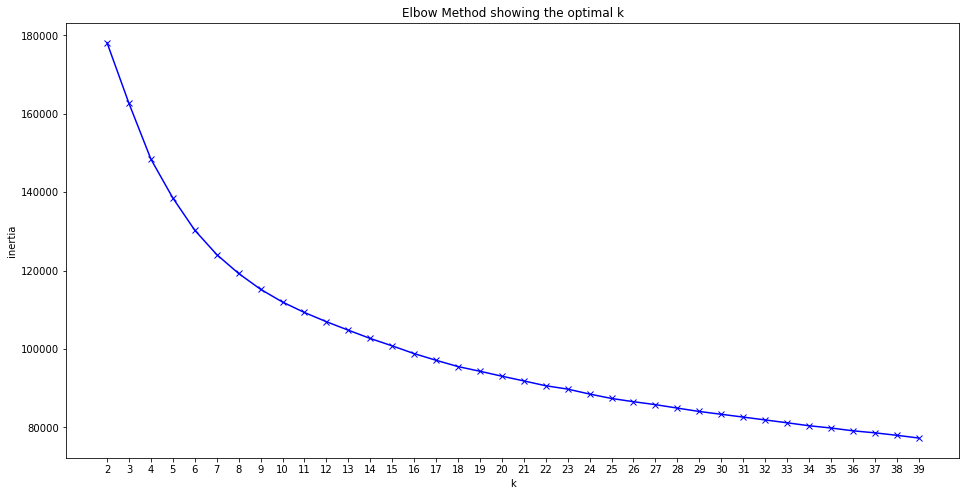

In [20]:
K = range(2, 40)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audio_df_prep)
    inertia.append(kmeans.inertia_)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

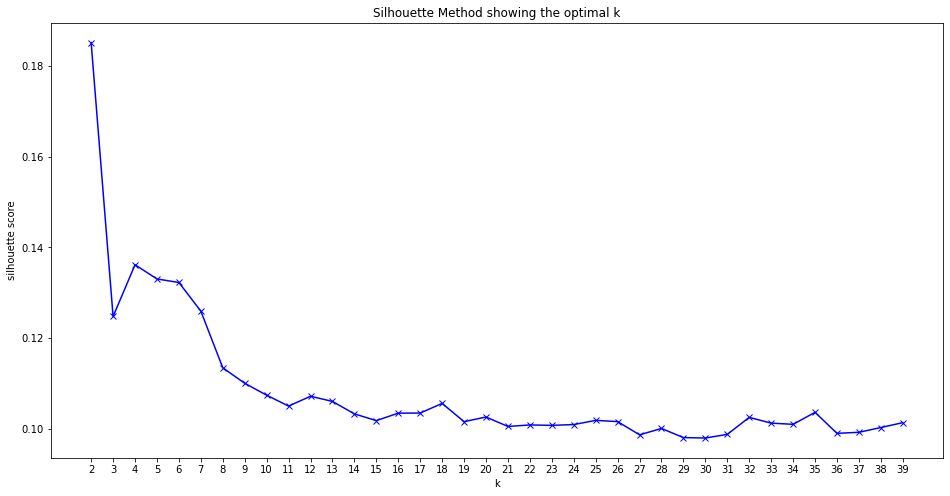

In [21]:
K = range(2, 40)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(audio_df_prep)
    silhouette.append(silhouette_score(audio_df_prep, kmeans.predict(audio_df_prep)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Silhouette Method showing the optimal k')

In [22]:
#Choosing 25

#### Clustering

In [23]:
kmeans = KMeans(n_clusters=25, random_state=1234)

In [24]:
kmeans.fit(audio_df_prep)

KMeans(n_clusters=25, random_state=1234)

In [25]:
clusters = kmeans.predict(audio_df_prep)

In [26]:
pd.Series(clusters).value_counts().sort_index()

0      895
1     1262
2      917
3      733
4      146
5      900
6      717
7     1013
8      713
9      909
10     965
11     301
12     606
13     934
14     463
15     974
16     743
17    1240
18     661
19     460
20     476
21     726
22     807
23     641
24     656
dtype: int64

#### Check cluster assignments?

In [27]:
Spotify_df = pd.DataFrame(Spotify)

In [28]:
Spotify_df["cluster"] = clusters

In [29]:
Spotify_df.head()

,Songtitle,Artist(s),uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster
0,beverly,Koi,spotify:track:2pTW1GkqQ6dPTBOff2ZqQc,0.735,0.491,0,-7.766,0,0.0427,0.15700,0.000060,0.121,0.5740,167.130,13
1,Titanium (feat. Sia),"David Guetta, Sia",spotify:track:47Z5890IcjSed81ldeLgqc,0.602,0.796,0,-3.657,0,0.1030,0.06820,0.120000,0.150,0.2650,126.060,13
2,LOVE. FEAT. ZACARI.,"Kendrick Lamar, Zacari",spotify:track:6PGoSes0D9eUDeeAafB2As,0.800,0.585,10,-7.343,1,0.0924,0.26400,0.000000,0.153,0.7790,126.058,1
3,do re mi,blackbear,spotify:track:3sTCfUmYXSVWDacTd6uMbQ,0.747,0.592,8,-6.334,1,0.0457,0.00517,0.000015,0.124,0.1760,110.991,17
4,Lord Of The Rings: The Fellowship Of The Ring ...,"Raine, The City of Prague Philharmonic Orchest...",spotify:track:2Twe7p278J2GxzjQZWJZWM,0.341,0.193,2,-16.915,1,0.0364,0.84800,0.923000,0.131,0.0749,104.448,4


# Prototype

Pseudocode:

User inputs song (not lower/uppercase sensitive)

Is the song in the Top 100?
    
    YES: Recommend another Song from the Top 100 list
    NO: as k for artist name then Match the song to one of the clusters and recommend a song from that cluster. if there is an index error try and except
    
note prototype 2: input matching cluster > get input-cluster#, recommend song with same cluster#

1)user input song call to spotify api to get audio features (combined search with artist and song?) get uri > get audio feautures

2)standart scaler to transform the feautures audio features k.means.predict cluster, then match

        

In [30]:
# Songinput (not lower/uppercase sensitive)
# Songinput = input("To teach Gnod what you are like, please type in 1 Song that you already know and like: ").lower()

In [31]:
# FUNCTIONS Notes

# Check if it is in the top 100
# Top_100.loc[Top_100['Songtitle'].str.lower() == Songinput]

# how to get Match
# Match = (Top_100.loc[Top_100['Songtitle'].str.lower() == Songinput])
# print(Match) > if its's a match it will show 1
# Match.shape[0] > so this will be 1 also ergo if Match.shape[0] is not 1 it is not a match

# Songrecommendation Top 100
    
def song_recommendation():
    Recommendation = Top_100.sample()
    return print("Songrecommendation: " + Recommendation.iloc[0,0] + " by " + Recommendation.iloc[0,1])


# Recommendation all

def Recommendation():
    Songinput  = input("To teach Gnod what you are like, please type in 1 Song that you already know and like: ").lower()
    Match = (Top_100.loc[Top_100['Songtitle'].str.lower() == Songinput])
    if Match.shape[0] == 1:
        song_recommendation()
    else:
        artist = input("Please also give us the artist of that song: ")
        try:
            result = sp.search(q="track:"+Songinput+" artist:"+artist,limit=1) #> get a json objects
            my_dict = sp.audio_features(result["tracks"]["items"][0]["uri"])[0]
            my_dict_2 = { key: [my_dict[key]] for key in list(my_dict.keys()) }
            df_1 = pd.DataFrame(my_dict_2)
            df_2 = df_1.drop(['type', 'id', 'uri', 'track_href','analysis_url', 'duration_ms', 'time_signature'], axis=1)
            df_2_prep = scaler.transform(df_2)
            clusters_1 = kmeans.predict(df_2_prep)
            recomm = Spotify_df[Spotify_df['cluster'] == clusters_1[0]].sample()
            print('Songrecommendation: ' + recomm.iloc[0,0] + " by " + recomm.iloc[0,1])
        except IndexError:
            print('Sorry, this song seems to be not existent.')


# App

In [33]:
Recommendation()

To teach Gnod what you are like, please type in 1 Song that you already know and like: up
Songrecommendation: Beat Box by SpotemGottem Featuring Pooh Shiesty Or DaBaby
